In [1]:
import os
import json
import yaml
import glob
import wandb
import glob2
import torch
import random
import pathlib
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
import seaborn as sns
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable

# Readability Classifier Dataset

## Dataset Overview

The Readability Classifier Dataset is designed for binary or multi-class classification tasks focused on determining the readability level of documents. This dataset is structured with a folder hierarchy to facilitate organization and labeling of documents based on different readability classes.

### Folder Structure:

The dataset follows a structured folder hierarchy as follows:

path-to-data

```
-- class 1
    -- img_1.jpeg
    -- img_2.jpeg
        .
        .
        
-- class 2
    -- img_1.jpeg
    -- img_2.jpeg
        .
        .
```

For example, 

- Binary Classification: Readable, Non-readable 
- Multiclass Classification: Printed, Mixed and Handwritten Document


### Input:
- `input_directory`: Path to the Readability Classifier dataset as exaplained above
- `output_directory`: Path to the output data dump of the train 

In [ ]:
import os
import random
import shutil

def split_train_test(input_dir, output_dir, train_ratio=0.8):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over the classes in the input directory
    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)
        if os.path.isdir(class_dir):
            # Get the list of files in the class directory
            files = os.listdir(class_dir)

            # Randomly shuffle the files
            random.shuffle(files)

            # Calculate the split index based on the train ratio
            split_index = int(len(files) * train_ratio)

            # Split the files into train and test sets
            train_files = files[:split_index]
            test_files = files[split_index:]

            # Create the train and test directories for the class
            train_class_dir = os.path.join(output_dir, 'train', class_name)
            test_class_dir = os.path.join(output_dir, 'test', class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            # Move the train files to the train directory
            for file in train_files:
                src = os.path.join(class_dir, file)
                dst = os.path.join(train_class_dir, file)
                shutil.copy(src, dst)

            # Move the test files to the test directory
            for file in test_files:
                src = os.path.join(class_dir, file)
                dst = os.path.join(test_class_dir, file)
                shutil.copy(src, dst)

            print(f"Splitting and copying files for class: {class_name}")

# Specify the input directory and output location
input_directory = '/data/user/nevil/document_classification/ground_truth/g4'
output_directory = '/data/user/nevil/document_classification/dataset/v4'

# Split the classes into train and test sets and copy them to the output location
split_train_test(input_directory, output_directory)


- Visualze a random 16 images

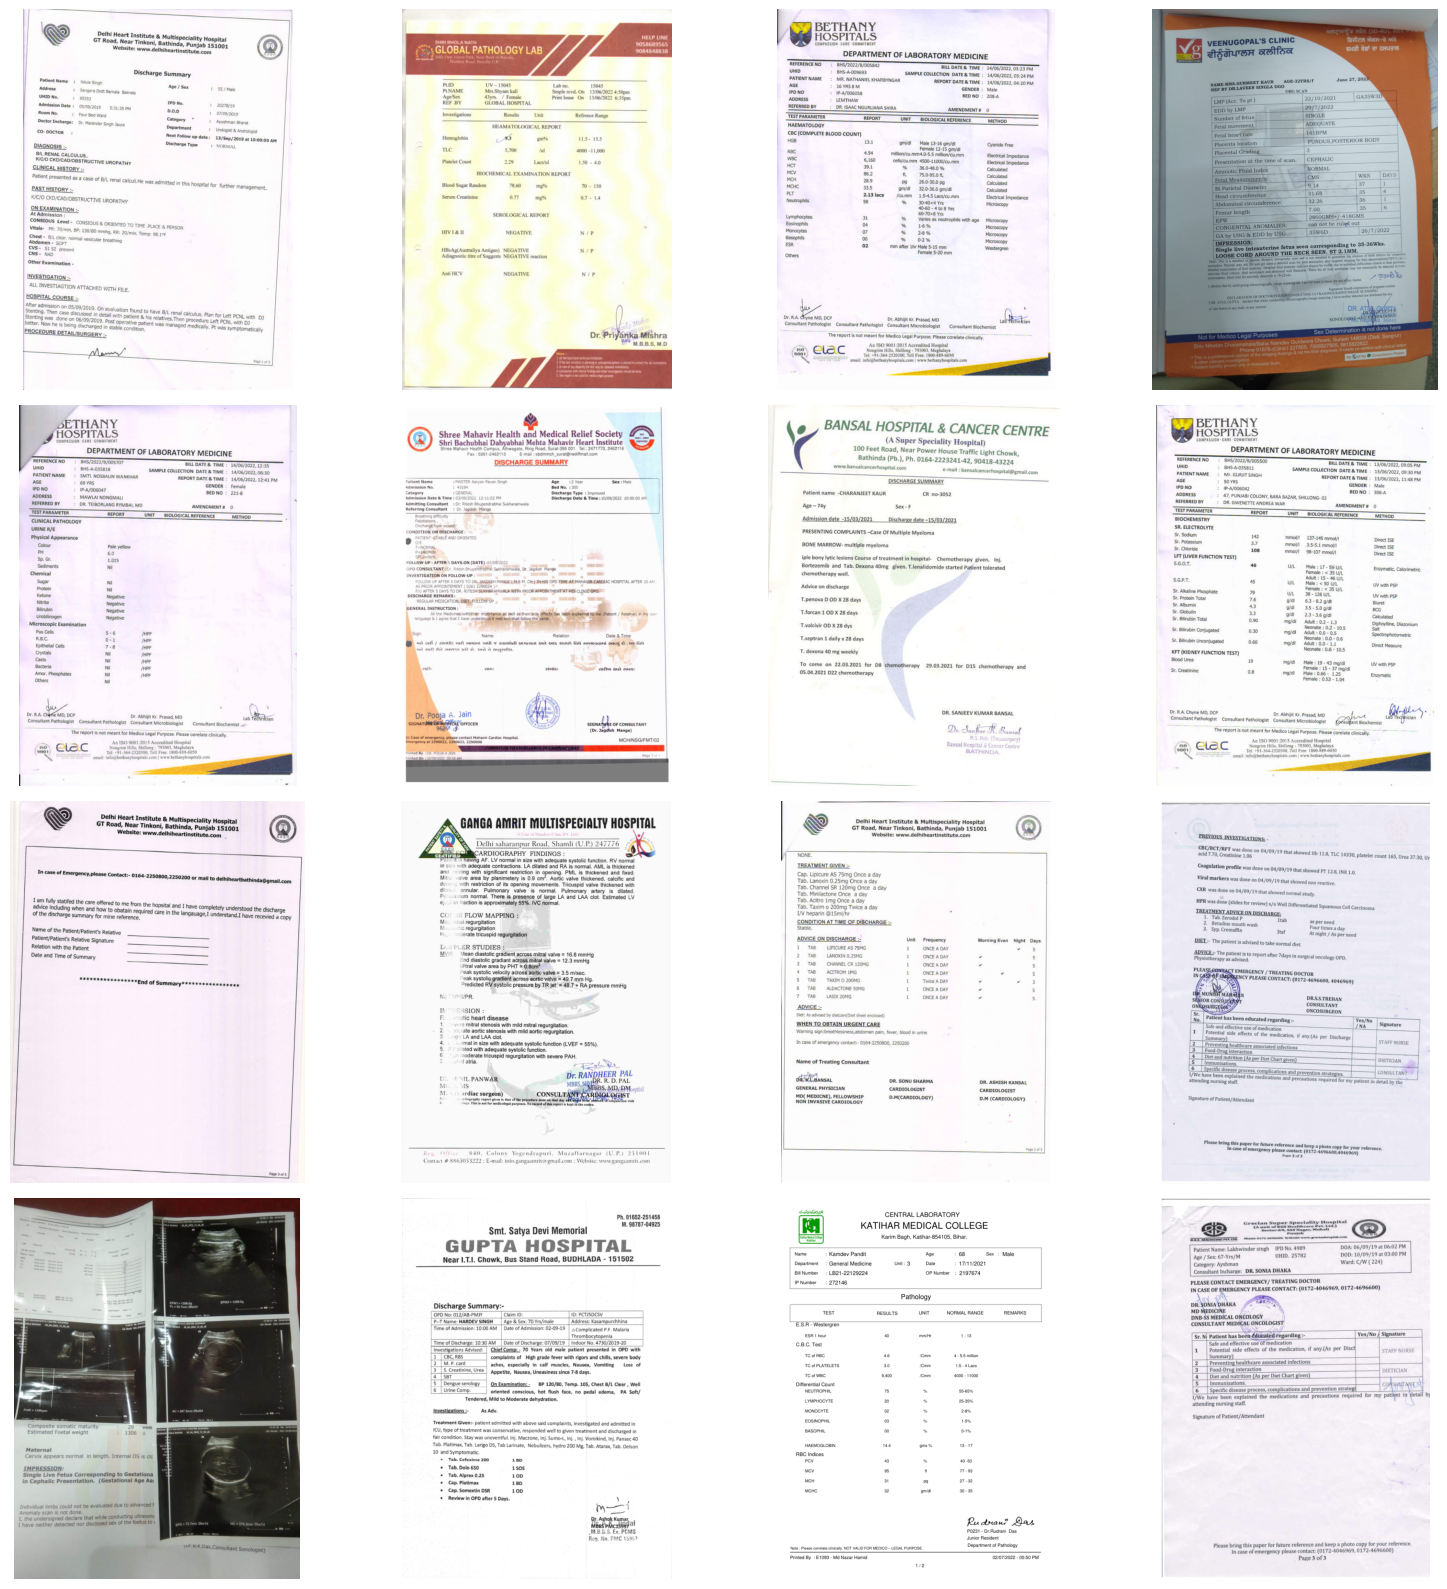

In [4]:
def display_images(images_dir, num_images=16, grid_size=(4, 4)):
    
    # Get a list of all the image files in the directory
    image_files = [file for file in os.listdir(images_dir) if file.endswith('.jpg') or file.endswith('.jpeg')]

    # Randomly select num_images images
    selected_images = random.sample(image_files, num_images)

    # Create the grid for image display
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(16, 16))

    # Iterate over the grid and display images
    for i, ax in enumerate(axs.flatten()):
        # Load and display the image
        image_path = os.path.join(images_dir, selected_images[i])
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Specify the directory containing the images
images_directory = '/data/user/nevil/document_classification/dataset/v4/train/printed'

# Display 16 random images in a 4x4 grid
display_images(images_directory, num_images=16, grid_size=(4, 4))


### 1. Load Dataset

In [6]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [7]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

transformer=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  
    transforms.Normalize([0.485, 0.456, 0.406], 
                        [0.229, 0.224, 0.225])
])

cuda


In [16]:
# Read config file
def read_yaml_file(file_path):
    with open(file_path, 'r') as yaml_file:
        config = yaml.safe_load(yaml_file)
    return config

def convert_yaml_to_json(config):
    
    config_json = json.dumps(config, indent=2)
    config_json = json.loads(config_json)
    return config_json

config_path = "../../configs/document_classification/resnet50.yaml"
config = read_yaml_file(config_path)
config_json = convert_yaml_to_json(config)
print(config['experiment_name'])

resnet50_v1.0


In [17]:
config_json

{'experiment_name': 'resnet50_v1.0',
 'checkpoint_path': '/data/user/nevil/document_classification/checkpoints',
 'model': {'name': 'resnet18',
  'activation': 'softmax',
  'parallel_training': True},
 'train': {'batch_size': 64,
  'epochs': 50,
  'learning_rate': 0.001,
  'weight_decay': 0.0001,
  'optimizer': 'adam',
  'loss_function': 'CrossEntropyLoss',
  'shuffle': True,
  'metrics': ['accuracy']},
 'test': {'batch_size': 32, 'shuffle': True},
 'data': {'path': '/data/user/nevil/document_classification/dataset',
  'data_version': 'v4',
  'preprocessing': [{'type': 'normalization'},
   {'type': 'augmentation',
    'params': {'rotation_range': 10,
     'width_shift_range': 0.1,
     'height_shift_range': 0.1,
     'horizontal_flip': True}}]}}

- prepare train & test data loader

In [18]:
train_path = join(config['data']['path'], config['data']['data_version'], "train")
test_path = join(config['data']['path'], config['data']['data_version'], "test")

train_loader=DataLoader(
    ImageFolderWithPaths(train_path,transform=transformer),
    batch_size=config_json['train']['batch_size'], shuffle=True
)
test_loader=DataLoader(
    ImageFolderWithPaths(test_path,transform=transformer),
    batch_size=config_json['test']['batch_size'], shuffle=True
)

In [19]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
classes_dict = { idx: class_name for idx, class_name in enumerate(classes)}
print(classes)

['other', 'printed']


#### Models

In [20]:
import torch
import torchvision.models as tvmodels
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import *

class resnet18(nn.Module):
    def __init__(self, num_classes, basemodel=tvmodels.resnet18, pretrained=True):
        super(resnet18, self).__init__()
        self.basemodel = basemodel(pretrained=pretrained)
        self.basemodel.fc = nn.Linear(
            in_features=512, out_features=num_classes, bias=True)

    def forward(self, x):
        x = self.basemodel(x)
        return x
    
class resnet50(nn.Module):
    def __init__(self, num_classes, basemodel=tvmodels.resnet50, pretrained=True):
        super(resnet50, self).__init__()
        self.basemodel = basemodel(pretrained=pretrained)
        self.basemodel.fc = nn.Linear(
            in_features=2048, out_features=num_classes, bias=True)

    def forward(self, x):
        x = self.basemodel(x)
        return x

- Load model and set loss function

In [22]:
def create_instance(class_name):
    try:
        # Get the class object using getattr()
        class_obj = globals()[class_name]
        return class_obj
    except AttributeError:
        print(f"Class '{class_name}' not found.")
        return None

In [23]:
# load model
model_class = create_instance(config['model']['name'])
if config['model']['parallel_training']: 
    model= nn.DataParallel(model_class(num_classes=len(classes)).to(device), device_ids=[0, 1, 2])
else: 
    model = model_class(num_classes=len(classes)).to(device)

# set loss function
optimizer=Adam(model.parameters(), lr=config['train']['learning_rate'], weight_decay=config['train']['weight_decay'])
loss_function = create_instance(config['train']['loss_function'])()

/data/env/envs/train_ml/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/env/envs/train_ml/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/data/env/envs/train_ml/lib/python3.8/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [24]:
num_epochs=config['train']['epochs']

- WANDB configration

### Training

In [25]:
# provide the path to save model checkpoints
# model will be saved under the folder with nmae of your experiment provided in yaml file
# don't add `/` at the end of the path
checkpoint_path = "path-to-save-your-model-checkpoitns"

In [ ]:
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images, labels, file_path) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
        del images, labels, file_path
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels, file_path) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)

        test_accuracy+=int(torch.sum(prediction==labels.data))
    
        del images, labels, file_path
        
    test_accuracy=test_accuracy/test_count
    
    # log metrics to wandb
    wandb.log({"train accuracy": train_accuracy, "train loss": train_loss, "test accuracy": test_accuracy})
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'{}/{}/best_checkpoint_v1.model'.format(checkpoint_path, config['experiment_name'])
        best_accuracy=test_accuracy


## Evalute the model

In [ ]:
# Load model
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

total_classes = 2
ckp_path = "path-to-the-best-checkpoint-of-your-model.model"

model = resnet50(total_classes)
model.to(device)
model.load_state_dict(torch.load(ckp_path))

In [ ]:
y_pred = list()
y_true = list()
file_paths = list()
for i, (images,labels, paths) in enumerate(test_loader):
    if torch.cuda.is_available():
        images=Variable(images.cuda())
        labels=Variable(labels.cuda())
    file_paths.extend(paths)
    
    outputs=model(images)
    _,prediction=torch.max(outputs.data,1)
    y_pred.extend([ x.item() for x in prediction])
    y_true.extend([ x.item() for x in labels])
    
print(len(y_pred), len(y_true))

In [ ]:
from sklearn.metrics import *
import numpy as np

print("Accuracy : ", accuracy_score(y_true, y_pred))
print("Precision : ", precision_score(y_true, y_pred, average="macro"))
print("Recall : ", recall_score(y_true, y_pred, average="macro"))

#get classification report
print(classification_report(y_true, y_pred))
#get confusion matrix
print(confusion_matrix(y_true, y_pred))

In [26]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes)